In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina' # I use a HiDPI screen

In [2]:
from __future__ import print_function
from pixell import enmap
import numpy as np
import matplotlib.pyplot as plt
from pixell import enplot
import scipy
import pymaster as nmt

# File Loading and Plotting

In [3]:
# import kfilter_share as kfilter

In [4]:
kx = 90
ky = 50
kx_apo = 0
ky_apo = 0
unpixwin = 1
d_th = 1/120.

In [5]:
import kfilter_share as kfilter

In [6]:
data_root = '/tigress/zequnl/cmb/data/'
# PA 1 -----
beam_filename = data_root + "/from_choi/beam/beam_tform_160201_s14_pa1_f150_jitter_CMB_deep56.txt"
beam_table = np.loadtxt(beam_filename)

lmax_beam = 30000
nsplits = 4

apopath = data_root + '/from_choi/apo_mask/deep56_c7v5_car_190220_rect_master_apo_w0.fits'
apo = enmap.read_map(apopath)
box = enmap.box(apo.shape,apo.wcs)

mapname_head = data_root + "/from_choi/maps/filtered/ACTPol_148_deep56_pa1_f150_s14_4way_split"
raw_maps = [enmap.read_map(f"{mapname_head}{i}_srcadd_I_filt_unpixwin.fits") for i in range(nsplits)]
boxed_maps = [rm.submap(box, mode='floor') for rm in raw_maps]
steve_maps = boxed_maps

weird_apo = apo.copy()
weird_apo[weird_apo <= 0.0] = 1e12

mapname_head = data_root + "/from_choi/maps/ACTPol_148_D56_pa1_f150_s14_4way_split"
raw_maps_f = [enmap.read_map(f"{mapname_head}{i}_srcadd_I.fits") for i in range(nsplits)]
boxed_maps_f = [rm.submap(box, mode='round') for rm in raw_maps_f]
no_wcs_maps = [
    kfilter.get_map_kx_ky_filtered_pyfftw(m * apo,d_th,kx,kx_apo,ky,ky_apo,unpixwin=unpixwin,zero_pad=False)
    for m in boxed_maps_f]
maps = [enmap.zeros(apo.shape, wcs=apo.wcs, dtype=apo.dtype) for i in range(nsplits)]


# maps = [maps_steve[i][:] for i in range(nsplits)]
for i in range(nsplits):
    maps[i][2:,1:] = no_wcs_maps[i][:-2,:-1] / weird_apo[1:-1, :-1]
# maps = [m / weird_apo for m in maps]


findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.


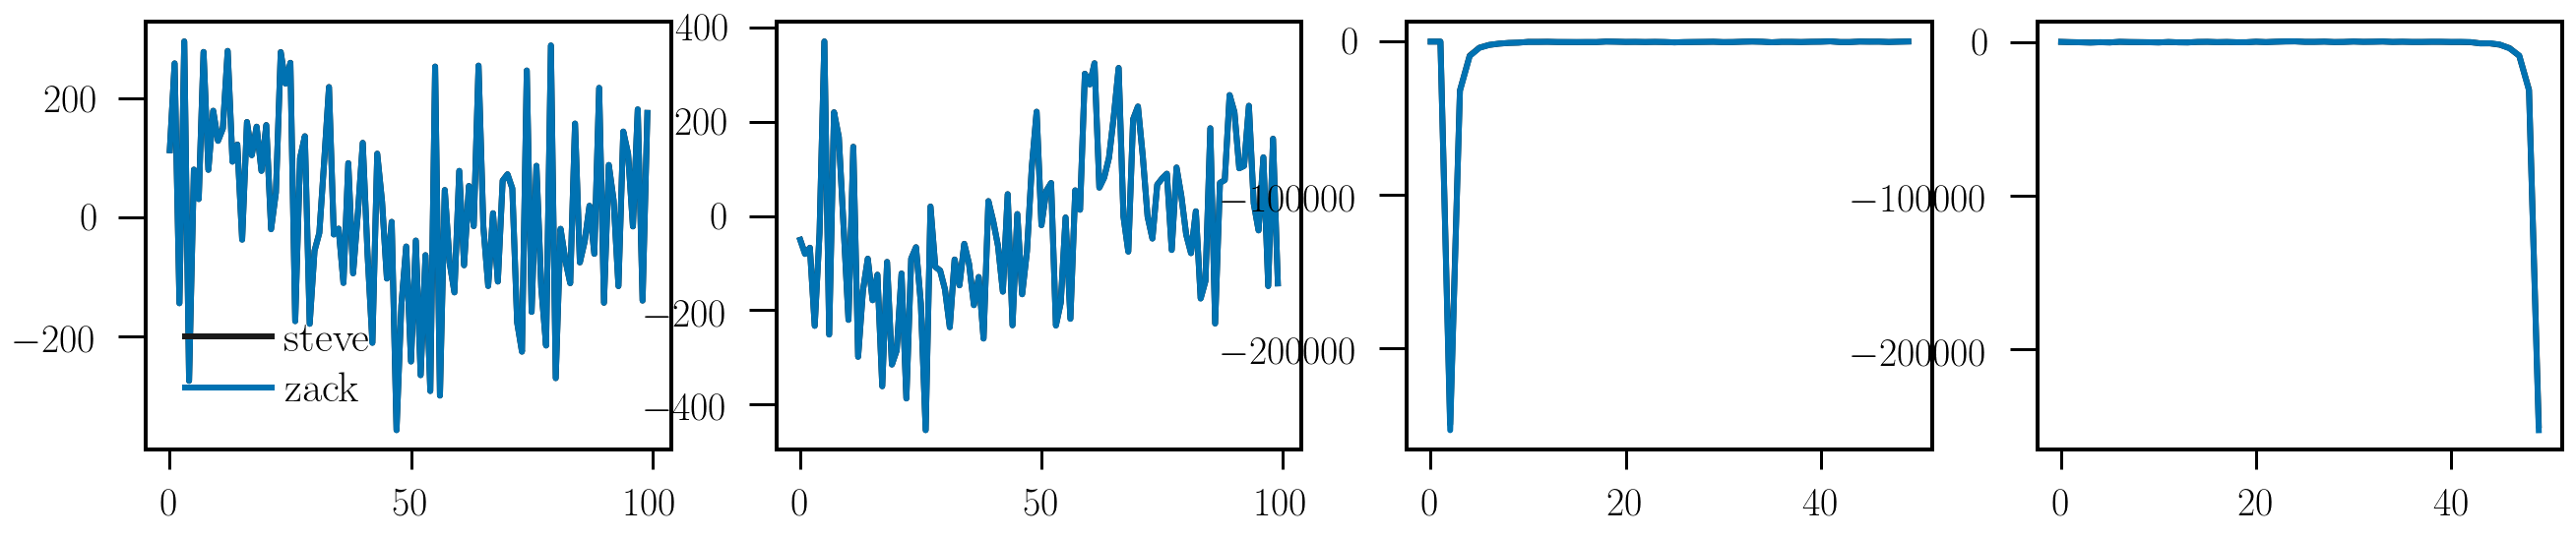

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(22,4))
axes[0].plot( steve_maps[0][500, 200:300], label='steve' )
axes[0].plot( maps[0][500, 200:300], label='zack' )
axes[0].legend()

axes[1].plot( steve_maps[0][200:300, 500] )
axes[1].plot( maps[0][200:300, 500] )

axes[2].plot( steve_maps[0][0:50, 500] )
axes[2].plot( maps[0][0:50, 500] )

axes[3].plot( steve_maps[0][-50:, 500] )
axes[3].plot( maps[0][-50:, 500] )

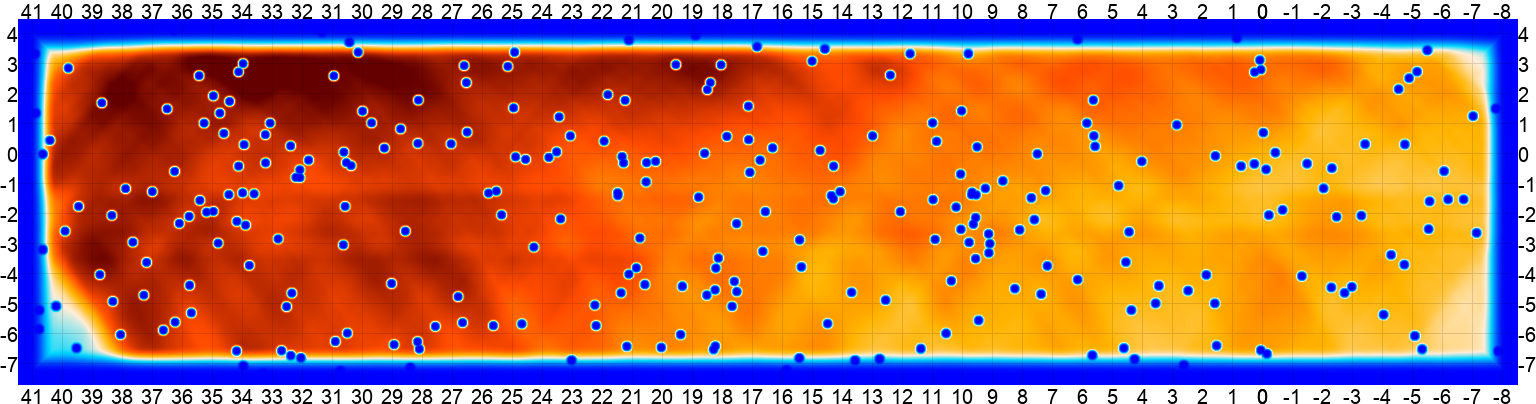

In [8]:
mask = enmap.read_fits(data_root + "/from_choi/window/deep56_s14_pa1_f150_c7v5_car_190220_rect_w0_cl0.00nK_pt1.00_nt0.0_T.fits")
mask *= apo
mask = mask.submap(box, mode='round')
plots = enplot.get_plots(mask, downgrade=4)
enplot.show(plots)

## Map

We show the unfiltered map, and the k-space filtered map.

In [9]:
# plots = enplot.get_plots(boxed_maps_f[0], range=400, downgrade=4)
# enplot.show(plots)

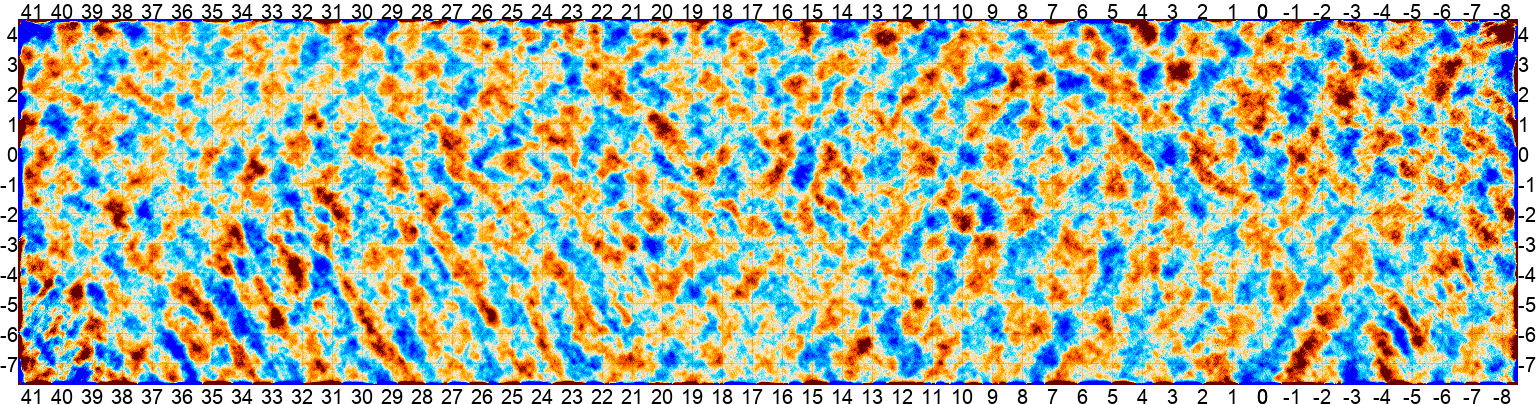

In [10]:
plots = enplot.get_plots(maps[0], range=400, downgrade=4)
enplot.show(plots)

## Beam

Text(0, 0.5, '$B_{\\ell}$')

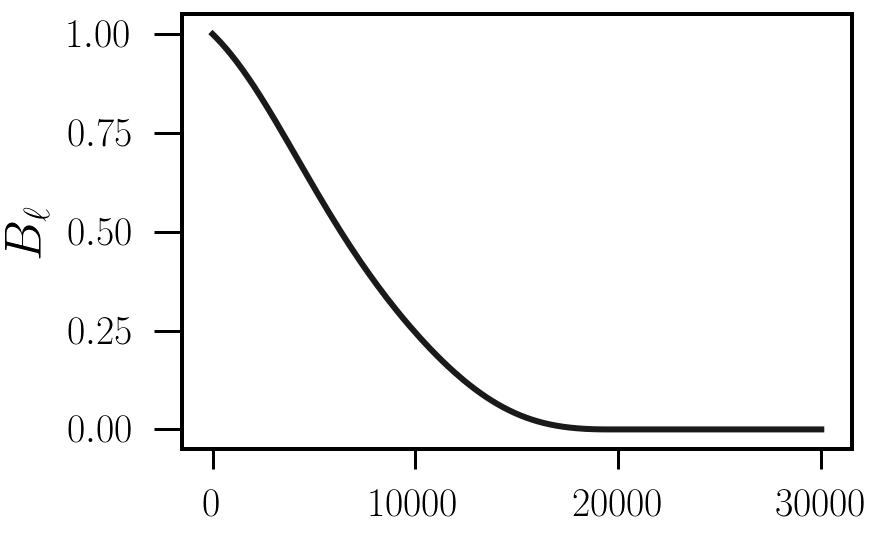

In [11]:
Bl = np.zeros(lmax_beam)
Bl[:beam_table.shape[0]] = beam_table[:,1].astype(float)
beam = Bl

plt.plot( np.arange(lmax_beam), beam)
plt.ylabel(r"$B_{\ell}$")

# Binning

In [12]:
binleft, binright, bincenter = np.loadtxt( data_root + '/from_choi/binning/BIN_ACTPOL_50_4_SC_low_ell', unpack=True, 
                                          dtype={'names': ('binleft', 'binright', 'bincenter'),
                                                 'formats': ('i', 'i', 'f')})
lmax = 7925
ells = np.arange(lmax)
bpws=-1+np.zeros_like(ells) #Array of bandpower indices
for i, (bl, br) in enumerate(zip(binleft[1:], binright[1:])):
    bpws[bl:br+1] = i
    
weights = np.array([1.0 / np.sum(bpws == bpws[l]) for l in range(lmax)])
b =nmt.NmtBin(2048,bpws=bpws,ells=ells,weights=weights, lmax=lmax, is_Dell=True)
lb = b.get_effective_ells()

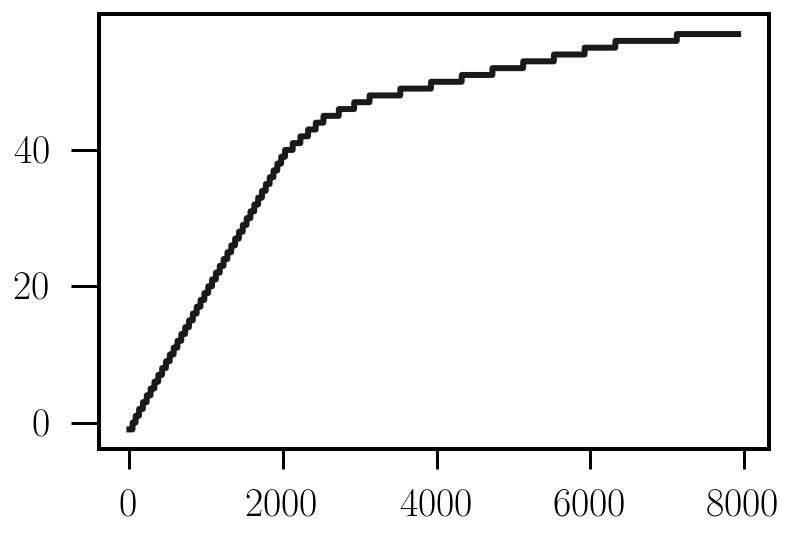

In [13]:
plt.plot(bpws)

# Power Spectra with NaMaster

## Quick Test
We compute the cross spectrum of splits 0 and 1.

In [14]:
niter = 0 # NaMaster-CAR only supports niter=0

field0 = nmt.NmtField(mask, [maps[0]], beam=beam, wcs=mask.wcs, n_iter=niter)
field1 = nmt.NmtField(mask, [maps[1]], beam=beam, wcs=mask.wcs, n_iter=niter)

In [15]:
b.get_effective_ells()

array([  60.5,  103. ,  150.5,  200.5,  250.5,  300.5,  350.5,  400.5,
        450.5,  500.5,  550.5,  600.5,  650.5,  700.5,  750.5,  800.5,
        850.5,  900.5,  950.5, 1000.5, 1050.5, 1100.5, 1150.5, 1200.5,
       1250.5, 1300.5, 1350.5, 1400.5, 1450.5, 1500.5, 1550.5, 1600.5,
       1650.5, 1700.5, 1750.5, 1800.5, 1850.5, 1900.5, 1950.5, 2000.5,
       2075.5, 2175.5, 2275.5, 2375.5, 2475.5, 2625.5, 2825.5, 3025.5,
       3325.5, 3725.5, 4125.5, 4525.5, 4925.5, 5325.5, 5725.5, 6034.5])

In [16]:
cl_coupled = nmt.compute_coupled_cell(field0, field1)
lb = b.get_effective_ells()
w0 = nmt.NmtWorkspace()
w0.compute_coupling_matrix(field0,field1, b, n_iter=niter)
Cb = w0.decouple_cell(cl_coupled)

(0, 3000)

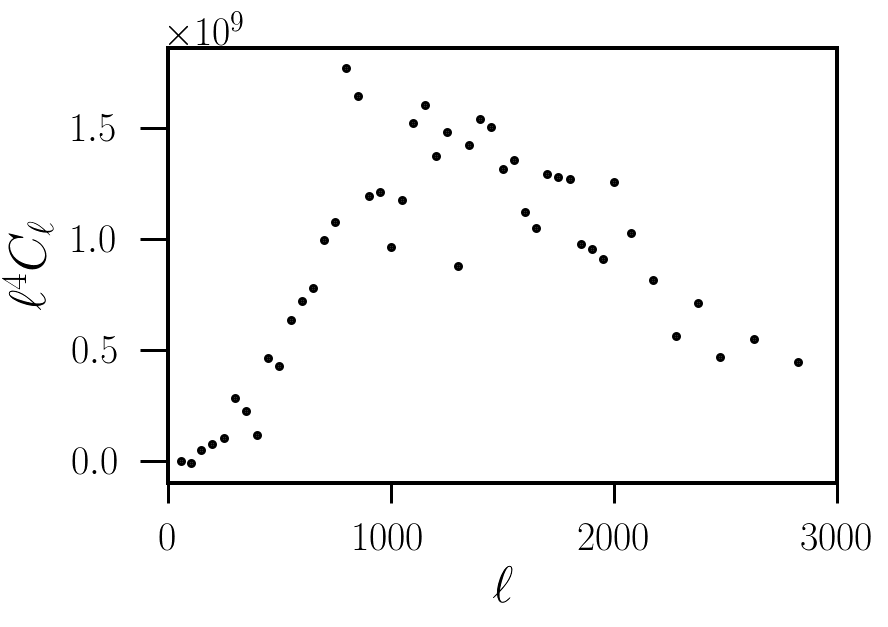

In [18]:
plt.plot( lb, Cb[0] * lb**2, 'k.' )
plt.ylabel(r"$\ell^4 C_{\ell}$")
plt.xlabel(r"$\ell$")
plt.xlim(0, 3000)
# plt.ylim(0, 35000)

## All Splits

In [19]:
ps_dict = {}
cross_spectra = []
fields = [nmt.NmtField(mask, [maps[i]], beam=beam, wcs=mask.wcs, n_iter=niter)
         for i in range(nsplits)]

# we can reuse the workspace w0 from earlier
for i in range(nsplits):
    for j in range(nsplits):
        if i >= j:
            cl_coupled = nmt.compute_coupled_cell(fields[i], fields[j])
            Cb = w0.decouple_cell(cl_coupled)
            ps_dict[f"{i},{j}"] = Cb
            if i > j:
                cross_spectra += [Cb[0]]

In [20]:
len(cross_spectra)

6

In [21]:
# we can reuse the workspace w0 from earlier
weighted_Cltt = np.zeros(len(lb))
noise_total = np.zeros(len(lb))

for i in range(nsplits):
    for j in range(nsplits):
        if i > j:
            noise_term = np.sqrt( ps_dict[f"{i},{i}"][0] * ps_dict[f"{j},{j}"][0] )
            weighted_Cltt += ps_dict[f"{i},{j}"][0] * noise_term
            noise_total += noise_term
            
weighted_Cltt /= noise_total

We can do a poor cosmologist's error bar by taking the standard errors of the cross spectra from the splits.

In [22]:
mean_Cltt = np.sum(cross_spectra, axis=0) / len(cross_spectra)
se_Cltt = np.std(cross_spectra, axis=0)/np.sqrt(len(cross_spectra))

(-100000000.0, 2500000000.0)

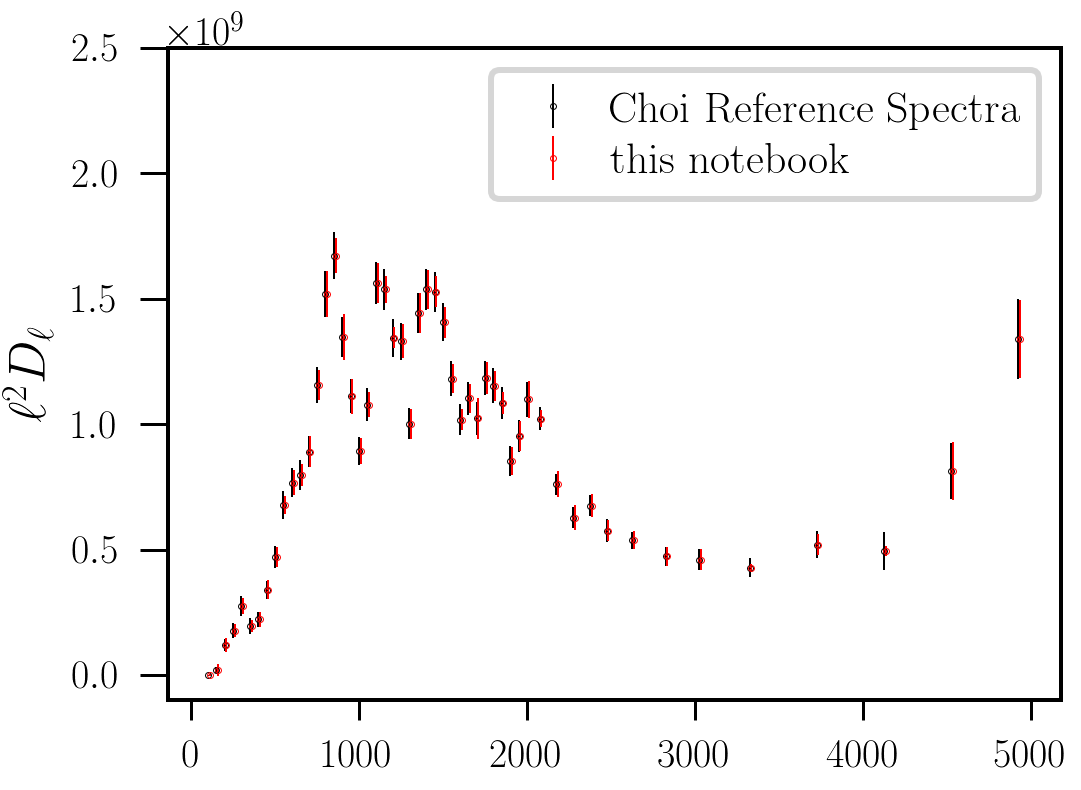

In [23]:
plt.figure(figsize=(8,6))

actual_cltt = np.loadtxt(data_root + "/from_choi/ps/deep56_s14_pa1_f150_c7v5_car_190220_rect_window0_TT_lmax7925_fsky0.01081284_output.txt")
choi_dl = actual_cltt[2:54,1]
choi_delta_dl = actual_cltt[2:54,2]
plt.errorbar( actual_cltt[2:54,0] , (choi_dl * actual_cltt[2:54,0]**2), 
             yerr = ( choi_delta_dl) * actual_cltt[2:54,0]**2, fmt='k.', lw=1, ms=1, label="Choi Reference Spectra" )

lbs = lb[1:-3]
notebook_dl = mean_Cltt[1:-3] 
plt.errorbar(lbs + 10, notebook_dl * lbs**2 , 
             fmt='r.', yerr=(notebook_dl / np.sqrt(2 * lbs + 1) + se_Cltt[1:-3]) * lbs**2  ,
             lw=1, ms=1, label="this notebook")
plt.ylabel(r"$\ell^2 D_{\ell}$")
plt.legend(frameon=True)
# plt.xlim(0,2800)
# plt.xscale("log")
plt.ylim(-1e8, 2.5e9)

Text(0.5, 1.0, 'notebook / Choi')

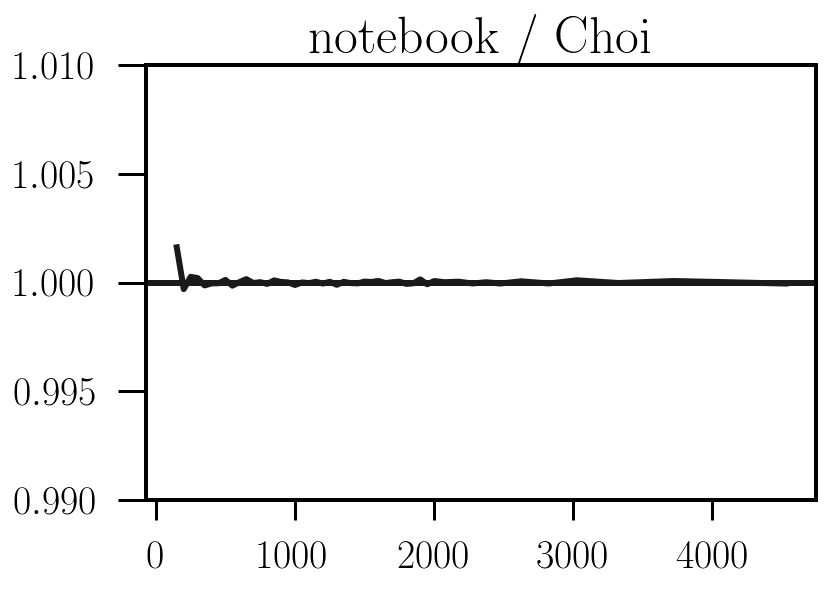

In [24]:
plt.plot( lbs[1:-1], (mean_Cltt[1:-3]  / choi_dl)[1:-1] )
plt.ylim(0.99, 1.01)
plt.axhline(1 )
plt.title("notebook / Choi")

Text(0.5, 1.0, '$\\Delta$PS  / Choi $\\sigma$')

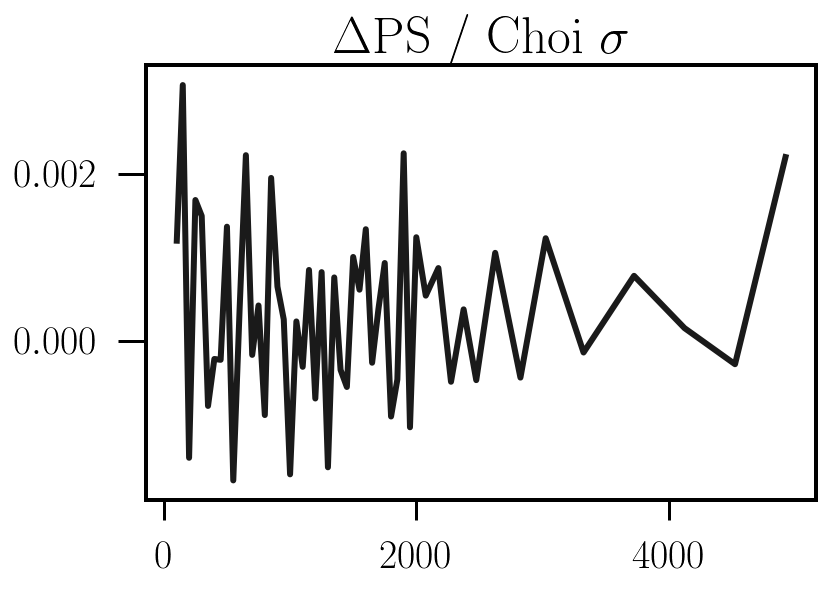

In [25]:
plt.plot( lbs, (notebook_dl - choi_dl) / choi_delta_dl )
plt.title("$\Delta$PS  / Choi $\sigma$")
# plt.ylim(-0.01, 0.01)